<h1>Brain tumor Detection!!</h1>
<h4> Prediscan Medtech Assessment</h4>

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=9d9bb0536e0ba20c21519938bb5fd589c88525509ba9957288a7c3fd7e5d5dd3
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.4/312.4 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 83.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# kaggle sample dataset url
# https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
image_dir = "../input/brain-mri-images-for-brain-tumor-detection"
augmented_data_path = "../output/kaggle/working/augmented-images/"

In [5]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from os import listdir
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected import statement
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import math
from PIL import Image
from scipy import misc
from os.path import isfile, join
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.utils import to_categorical

from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import gradio as gr

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
os.makedirs(augmented_data_path, exist_ok = True)
os.makedirs(augmented_data_path + "yes", exist_ok = True)
os.makedirs(augmented_data_path + "no", exist_ok = True)

In [7]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    if not os.path.exists(file_dir):
        raise FileNotFoundError(f"Input directory not found: {file_dir}")

    data_gen = ImageDataGenerator (
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        brightness_range = (0.3, 1.0),
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest'
    )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0

        # Indent the following lines within the for loop
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = 'jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [8]:
augment_data(file_dir = image_dir + "/yes", n_generated_samples = 6, save_to_dir = augmented_data_path + "yes")
augment_data(file_dir = image_dir + "/no", n_generated_samples = 9, save_to_dir = augmented_data_path + "no")

In [9]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

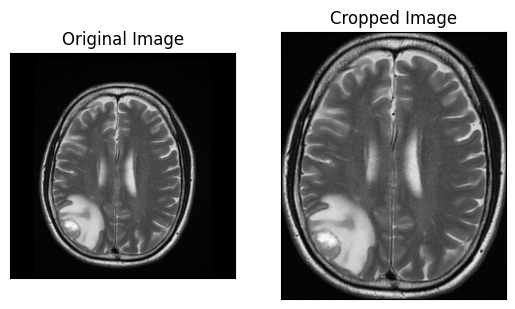

In [10]:
ex_img_path = os.path.join(image_dir, 'yes', 'Y107.jpg')
ex_img = cv2.imread(ex_img_path)

ex_crop_img = crop_brain_contour(ex_img, True)

In [11]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [12]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [13]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

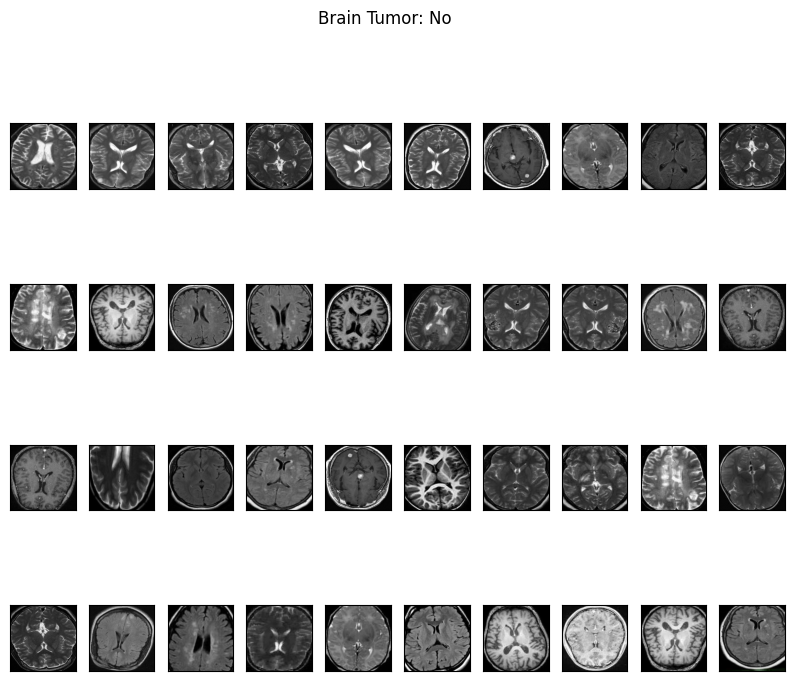

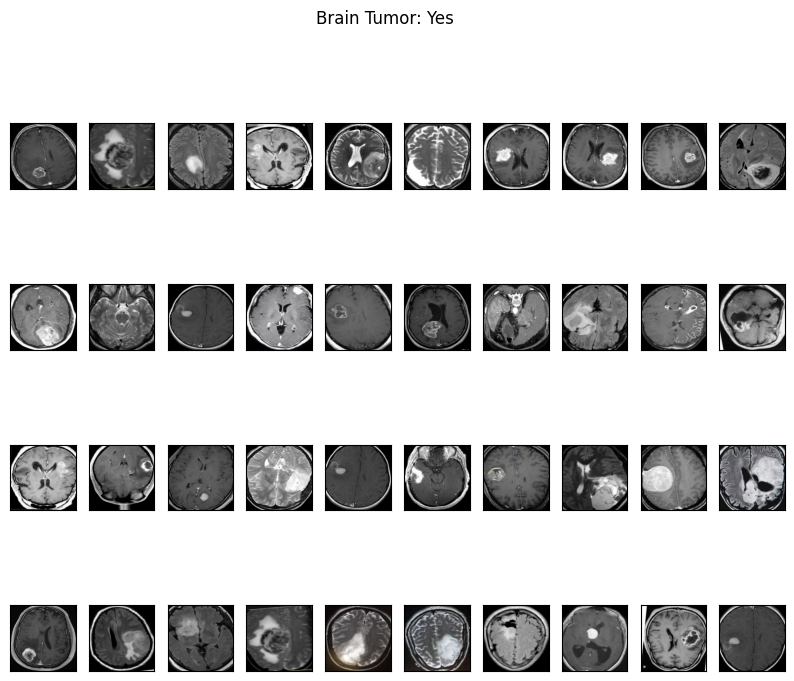

In [14]:
plot_sample_images(X, y)

In [15]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


In [18]:
IMG_SHAPE = (240, 240, 3)  # Adjust the dimensions based on your specific input shape

# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SHAPE
)


2024-04-01 05:36:36.610753: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-04-01 05:36:36.610853: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-04-01 05:36:36.610938: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-04-01 05:36:36.611027: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-04-01 05:36:36.611105: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-04-01 05:36:36.611313: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-04-01 05:36:36.611405: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [19]:
model = Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
46/46 [==============================] - 42s 900ms/step - loss: 0.5523 - accuracy: 0.7204 - val_loss: 0.3769 - val_accuracy: 0.8484
Epoch 2/10
46/46 [==============================] - 41s 888ms/step - loss: 0.2843 - accuracy: 0.8851 - val_loss: 0.2306 - val_accuracy: 0.9290
Epoch 3/10
46/46 [==============================] - 41s 896ms/step - loss: 0.1831 - accuracy: 0.9419 - val_loss: 0.1880 - val_accuracy: 0.9516
Epoch 4/10
46/46 [==============================] - 41s 892ms/step - loss: 0.1523 - accuracy: 0.9564 - val_loss: 0.1642 - val_accuracy: 0.9613
Epoch 5/10
46/46 [==============================] - 41s 888ms/step - loss: 0.1105 - accuracy: 0.9785 - val_loss: 0.1389 - val_accuracy: 0.9677
Epoch 6/10
46/46 [==============================] - 41s 884ms/step - loss: 0.0991 - accuracy: 0.9702 - val_loss: 0.1252 - val_accuracy: 0.9645
Epoch 7/10
46/46 [==============================] - 40s 882ms/step - loss: 0.0879 - accuracy: 0.9813 - val_loss: 0.1172 - val_accuracy: 0.9774

In [21]:
# y_pred = model.predict(X_test)
# threshold = 0.5
# y_pred_binary = (y_pred >= threshold).astype(int)

# # Create a confusion matrix
# cm = confusion_matrix(y_test, y_pred_binary)

# # Plot the confusion matrix using seaborn
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()


In [22]:
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test loss:', score[0])


 Test accuracy: 0.977419376373291

 Test loss: 0.09726826101541519


In [23]:
import gradio as gr

# Create the Gradio interface function
def predict_tumor(img):
    # Preprocess the uploaded image
    img = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    result = "Yes, there's a tumor" if prediction[0][0] > 0.5 else "No, there's not a tumor"
    
    return result

# Create Gradio interface
iface = gr.Interface(fn=predict_tumor, inputs="image", outputs="text", live=True)
iface.launch()


Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://d30fb4c54d098803e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


https://symbolize.stripped_domain/r/?trace=7dad6ece7c66,7dad6ec1afcf&map= 
*** SIGTERM received by PID 13 (TID 13) on cpu 68 from PID 1; stack trace: ***
PC: @     0x7dad6ece7c66  (unknown)  epoll_wait
    @     0x7dac880c6ada       1152  (unknown)
    @     0x7dad6ec1afd0  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7dad6ece7c66,7dac880c6ad9,7dad6ec1afcf&map=a72dc8804ea1afe30400d5b599dccd5c:7dac7ac00000-7dac882d7370 
E0401 05:43:49.489238      13 coredump_hook.cc:393] RAW: Remote crash gathering disabled for SIGTERM.
